In [92]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os

In [93]:
elementType="Q2/DPC1"
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (24, 24), 
                                 minCoord    = (-0.5, 0.), 
                                 maxCoord    = (0.5, 1.)) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

In [94]:
velocityField.data[:] = 0
pressureField.data[:] = 0

In [95]:
coordinate = fn.input()

In [96]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]

In [97]:
def circleFn(centre, radius):
    _circFn = (((coordinate[0] - centre[0])**2) + ((coordinate[1] - centre[1])**2)) < radius**2
    return _circFn

circ1 = circleFn((-0.25, 0.8), 0.05)

In [98]:
nodes = circ1.evaluate(mesh).nonzero()[0]

velocityField.data[nodes]= [1.0,0.]

drivenVel = mesh.specialSets["Empty"]

#if uw.rank() == 0:
drivenVel.add(nodes)  

drivenVel = drivenVel #- lWalls - bWalls

In [99]:
print("internal fixed nodes count: ", len(nodes))

('internal fixed nodes count: ', 16)


In [100]:
velDbc = uw.conditions.DirichletCondition( variable      = velocityField, 
  
                                              indexSetsPerDof = ( iWalls + drivenVel, jWalls + drivenVel) )

In [101]:
viscosity = fn.misc.constant(1.0)

In [102]:
stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velDbc,],
                                   fn_viscosity   = viscosity, 
                                   fn_bodyforce   = (0., 0.) )

In [103]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Surface(mesh, circ1, pointSize=3, discrete=True))
fig.append( glucifer.objects.VectorArrows(mesh, velocityField*1.  ))
fig.append( glucifer.objects.Mesh(mesh, opacity = 0.3  ))

#fig.show()

In [104]:
solver = uw.systems.Solver(stokesPIC)
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4

In [105]:
#solver.solve()
solver.solve(nonLinearIterate=True)



In [106]:
figVel= glucifer.Figure(quality=3)

figVel.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField)))
figVel.append( glucifer.objects.Surface(mesh, circ1))

figVel.append( glucifer.objects.VectorArrows(mesh, velocityField*1.  ))
figVel.append( glucifer.objects.Mesh(mesh, opacity = 0.3  ))

In [107]:
figVel.save_image('vel.png')
figVel.save_database('vel.gldb')

'vel.gldb'


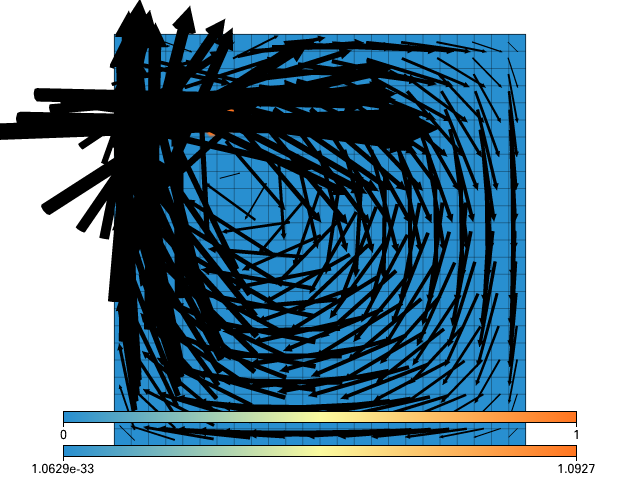

In [109]:
figVel.show()